In [1]:
pip install torch torchvision torchaudio


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [82]:
import torch
from torchvision import datasets, transforms

test_transform = transforms.Compose([
    transforms.ToTensor()
])


# Only normalization for test set (no augmentation)
test_transform = transforms.Compose([
    transforms.ToTensor()
])

# Use different transforms for train and test
train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=train_transform
)

test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=test_transform
)


# Download + Load training set
train_data = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

# Download + Load test set
test_data = datasets.FashionMNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

print("Train samples:", len(train_data))
print("Test samples:", len(test_data))
print("Image shape:", train_data[0][0].shape)  # Should be [1, 28, 28]


Train samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])


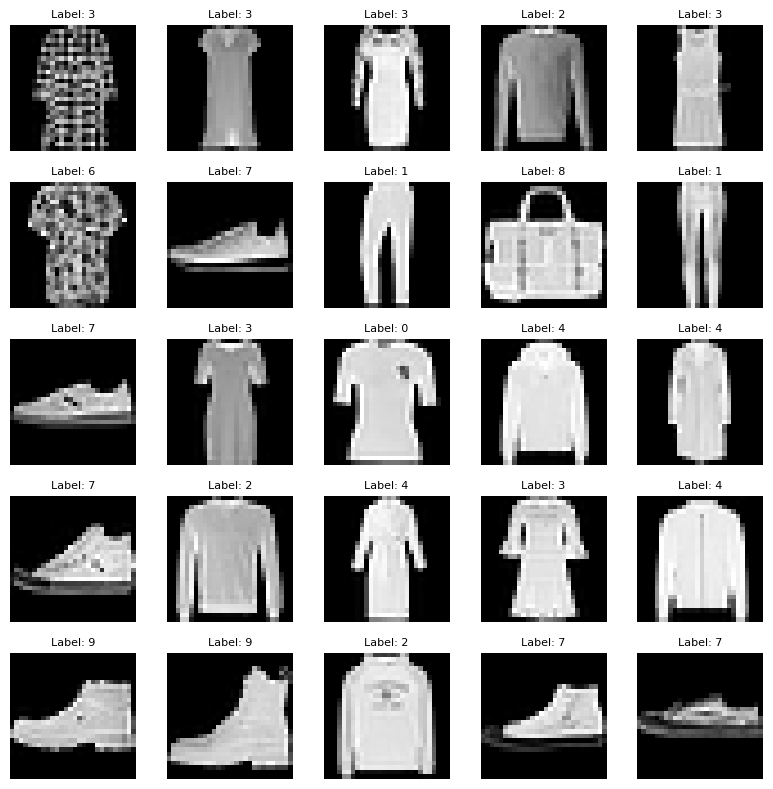

In [83]:
import matplotlib.pyplot as plt
import torch

# Display 25 random images from the training set
plt.figure(figsize=(8, 8))

for i in range(25):
    index = torch.randint(0, len(train_data), (1,)).item()
    img, label = train_data[index]
    img = img.squeeze(0)  # remove channel dimension (1,28,28) -> (28,28)
    
    plt.subplot(5, 5, i+1)
    plt.imshow(img, cmap="gray")
    plt.title(f"Label: {label}", fontsize=8)
    plt.axis("off")

plt.tight_layout()
plt.show()


# Softmax Regression baseline


In [57]:
import torch
from torch.utils.data import DataLoader

batch_size = 128  # you can change this if you want

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data,  batch_size=batch_size, shuffle=False)

len(train_loader), len(test_loader)


(469, 79)

In [58]:
import torch.nn as nn

class SoftmaxRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Flatten 1×28×28 -> 784
        self.flatten = nn.Flatten()
        # Linear layer: 784 inputs -> 10 classes
        self.linear = nn.Linear(28*28, 10)

    def forward(self, x):
        x = self.flatten(x)       # shape: (batch_size, 784)
        logits = self.linear(x)   # shape: (batch_size, 10)
        return logits

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

model = SoftmaxRegression().to(device)


Device: cpu


In [59]:
criterion = nn.CrossEntropyLoss()          # combines LogSoftmax + NLLLoss
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)


In [60]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate stats
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    test_loss,  test_acc  = evaluate(model, test_loader,  criterion, device)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc*100:.2f}%, "
          f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc*100:.2f}%")


Epoch 01: Train Loss = 0.6880, Train Acc = 77.22%, Test Loss = 0.5635, Test Acc = 81.12%
Epoch 02: Train Loss = 0.5209, Train Acc = 82.43%, Test Loss = 0.5339, Test Acc = 81.48%
Epoch 03: Train Loss = 0.4869, Train Acc = 83.58%, Test Loss = 0.5096, Test Acc = 82.00%
Epoch 04: Train Loss = 0.4689, Train Acc = 84.16%, Test Loss = 0.5041, Test Acc = 82.15%
Epoch 05: Train Loss = 0.4568, Train Acc = 84.56%, Test Loss = 0.4877, Test Acc = 82.66%
Epoch 06: Train Loss = 0.4486, Train Acc = 84.61%, Test Loss = 0.4923, Test Acc = 82.36%
Epoch 07: Train Loss = 0.4411, Train Acc = 84.93%, Test Loss = 0.4807, Test Acc = 82.73%
Epoch 08: Train Loss = 0.4344, Train Acc = 85.15%, Test Loss = 0.4649, Test Acc = 83.58%
Epoch 09: Train Loss = 0.4312, Train Acc = 85.20%, Test Loss = 0.4820, Test Acc = 82.55%
Epoch 10: Train Loss = 0.4276, Train Acc = 85.41%, Test Loss = 0.4748, Test Acc = 83.53%


# MLP


In [61]:
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.net = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)   # (batch, 784)
        logits = self.net(x)  # (batch, 10)
        return logits

mlp_model = MLP().to(device)
print(mlp_model)


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [62]:
optimizer_mlp = torch.optim.Adam(mlp_model.parameters(), lr=1e-3)



In [63]:
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(mlp_model, train_loader, optimizer_mlp, criterion, device)
    test_loss,  test_acc  = evaluate(mlp_model, test_loader,  criterion, device)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc*100:.2f}%, "
          f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc*100:.2f}%")


Epoch 01: Train Loss = 0.5698, Train Acc = 80.05%, Test Loss = 0.4557, Test Acc = 83.69%
Epoch 02: Train Loss = 0.3864, Train Acc = 86.04%, Test Loss = 0.4169, Test Acc = 84.62%
Epoch 03: Train Loss = 0.3418, Train Acc = 87.58%, Test Loss = 0.3700, Test Acc = 86.68%
Epoch 04: Train Loss = 0.3210, Train Acc = 88.16%, Test Loss = 0.3656, Test Acc = 86.69%
Epoch 05: Train Loss = 0.2979, Train Acc = 89.07%, Test Loss = 0.3559, Test Acc = 87.20%
Epoch 06: Train Loss = 0.2865, Train Acc = 89.42%, Test Loss = 0.3406, Test Acc = 87.99%
Epoch 07: Train Loss = 0.2699, Train Acc = 90.05%, Test Loss = 0.3346, Test Acc = 88.05%
Epoch 08: Train Loss = 0.2611, Train Acc = 90.21%, Test Loss = 0.3257, Test Acc = 88.39%
Epoch 09: Train Loss = 0.2492, Train Acc = 90.74%, Test Loss = 0.3264, Test Acc = 88.59%
Epoch 10: Train Loss = 0.2417, Train Acc = 90.97%, Test Loss = 0.3205, Test Acc = 88.70%


# CNN

In [84]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional feature extractor
        self.conv_layer = nn.Sequential(
            # Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),          # 28x28 -> 14x14

            # Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)           # 14x14 -> 7x7
        )

        # Fully connected classifier
        self.fc_layer = nn.Sequential(
            nn.Flatten(),             # 64*7*7 = 3136
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.4),          # Dropout to reduce overfitting
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.fc_layer(x)
        return x

# Create model as before (the name stays cnn_model so all later code still works)
cnn_model = CNN().to(device)


In [85]:
optimizer_cnn = torch.optim.Adam(cnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()


In [86]:
num_epochs = 10

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(cnn_model, train_loader, optimizer_cnn, criterion, device)
    test_loss,  test_acc  = evaluate(cnn_model, test_loader,  criterion, device)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

    print(f"Epoch {epoch:02d}: "
          f"Train Loss = {train_loss:.4f}, Train Acc = {train_acc*100:.2f}%, "
          f"Test Loss = {test_loss:.4f}, Test Acc = {test_acc*100:.2f}%")


Epoch 01: Train Loss = 0.4593, Train Acc = 83.47%, Test Loss = 0.3403, Test Acc = 87.77%
Epoch 02: Train Loss = 0.3184, Train Acc = 88.50%, Test Loss = 0.2747, Test Acc = 89.95%
Epoch 03: Train Loss = 0.2807, Train Acc = 89.90%, Test Loss = 0.2582, Test Acc = 90.61%
Epoch 04: Train Loss = 0.2541, Train Acc = 90.77%, Test Loss = 0.2459, Test Acc = 90.75%
Epoch 05: Train Loss = 0.2326, Train Acc = 91.54%, Test Loss = 0.2465, Test Acc = 90.81%
Epoch 06: Train Loss = 0.2168, Train Acc = 92.04%, Test Loss = 0.2314, Test Acc = 91.67%
Epoch 07: Train Loss = 0.2002, Train Acc = 92.64%, Test Loss = 0.2271, Test Acc = 92.01%
Epoch 08: Train Loss = 0.1884, Train Acc = 93.01%, Test Loss = 0.2252, Test Acc = 91.89%
Epoch 09: Train Loss = 0.1740, Train Acc = 93.50%, Test Loss = 0.2248, Test Acc = 92.13%
Epoch 10: Train Loss = 0.1648, Train Acc = 93.95%, Test Loss = 0.2220, Test Acc = 92.11%


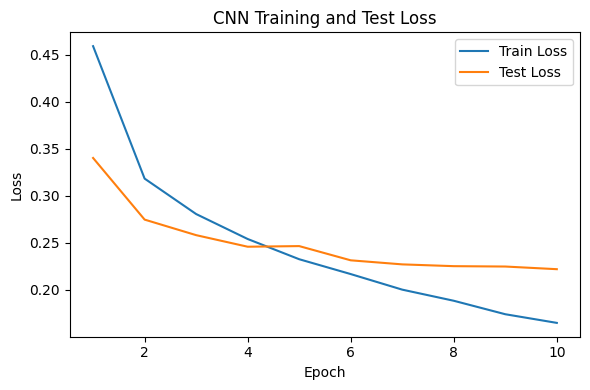

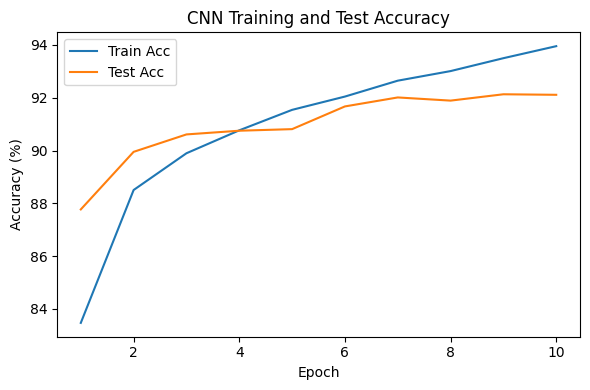

In [87]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# 1. Loss 
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("CNN Training and Test Loss")
plt.legend()
plt.tight_layout()
plt.show()

# 2. Accuracy 
plt.figure(figsize=(6, 4))
plt.plot(epochs, [a * 100 for a in train_accuracies], label="Train Acc")
plt.plot(epochs, [a * 100 for a in test_accuracies], label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("CNN Training and Test Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [68]:
!pip install seaborn


3813.93s - pydevd: Sending message related to process being replaced timed-out after 5 seconds



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


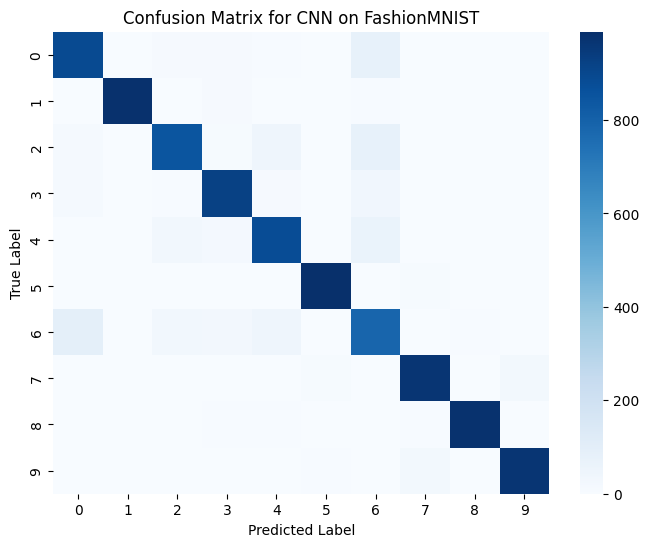

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

# 1. 将 test set 全部跑一遍
all_preds = []
all_labels = []

cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

# 2. 计算混淆矩阵
cm = confusion_matrix(all_labels, all_preds)

# 3. 可视化
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap="Blues", fmt="d")
plt.title("Confusion Matrix for CNN on FashionMNIST")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


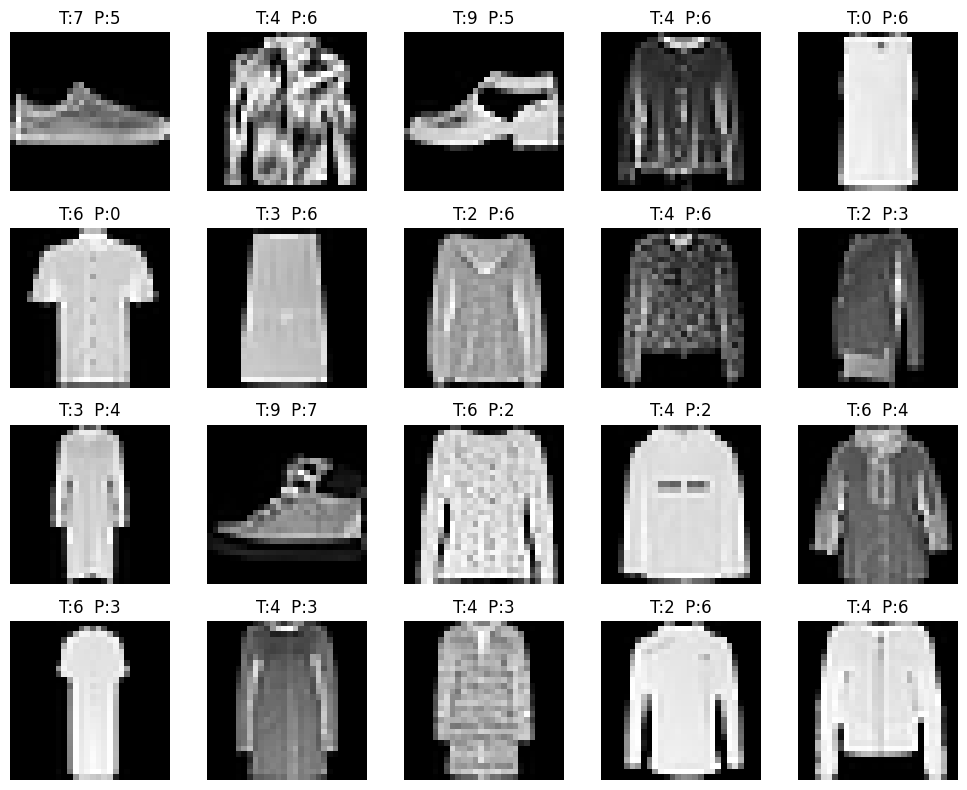

In [70]:
import matplotlib.pyplot as plt

misclassified_images = []
misclassified_true = []
misclassified_pred = []

cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = cnn_model(images)
        preds = outputs.argmax(dim=1)

        mismatches = preds != labels
        for img, true, pred in zip(images[mismatches], labels[mismatches], preds[mismatches]):
            misclassified_images.append(img.cpu())
            misclassified_true.append(true.item())
            misclassified_pred.append(pred.item())

        if len(misclassified_images) >= 20:
            break

# Plot 20 misclassified samples
plt.figure(figsize=(10, 8))
for i in range(20):
    plt.subplot(4, 5, i+1)
    plt.imshow(misclassified_images[i].squeeze(), cmap="gray")
    plt.title(f"T:{misclassified_true[i]}  P:{misclassified_pred[i]}")
    plt.axis("off")

plt.tight_layout()
plt.show()


# pca

In [71]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Take a subset of training data for PCA (e.g., 10,000 samples)
n_samples = 10000
x_pca = []
y_pca = []

for images, labels in train_loader:
    # Flatten images: (batch, 1, 28, 28) → (batch, 784)
    batch_size = images.size(0)
    x_pca.append(images.view(batch_size, -1).numpy())
    y_pca.append(labels.numpy())

    # Stop once we reach the desired sample size
    if sum(len(b) for b in y_pca) >= n_samples:
        break

# Concatenate and keep exactly n_samples
x_pca = np.concatenate(x_pca, axis=0)[:n_samples]  # Shape: (n_samples, 784)
y_pca = np.concatenate(y_pca, axis=0)[:n_samples]  # Shape: (n_samples,)

print(x_pca.shape, y_pca.shape)


(10000, 784) (10000,)


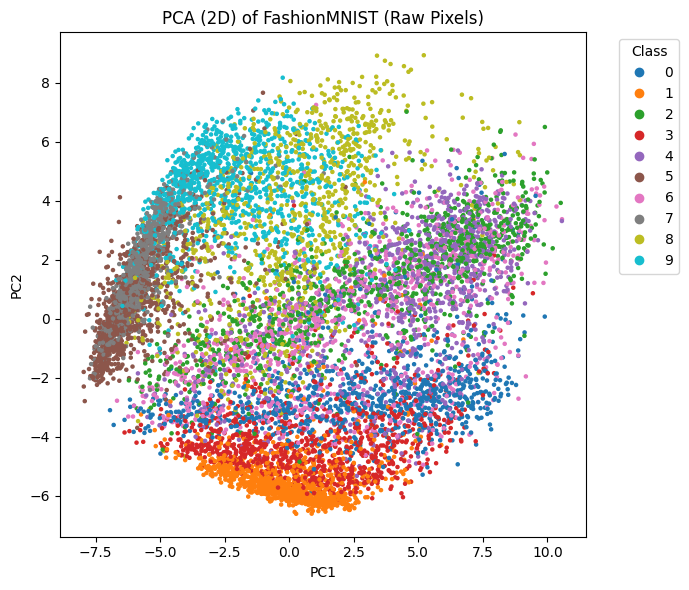

In [72]:
# Apply PCA to reduce dimensionality to 2 components
pca_2d = PCA(n_components=2)
x_pca_2d = pca_2d.fit_transform(x_pca)  # Shape: (n_samples, 2)

# Plot the 2D scatter plot colored by label
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    x_pca_2d[:, 0],
    x_pca_2d[:, 1],
    c=y_pca,
    s=5,
    cmap="tab10"
)

plt.title("PCA (2D) of FashionMNIST (Raw Pixels)")
plt.xlabel("PC1")
plt.ylabel("PC2")

# Add legend for 10 classes
handles, labels = scatter.legend_elements(num=10)
plt.legend(handles, labels, title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


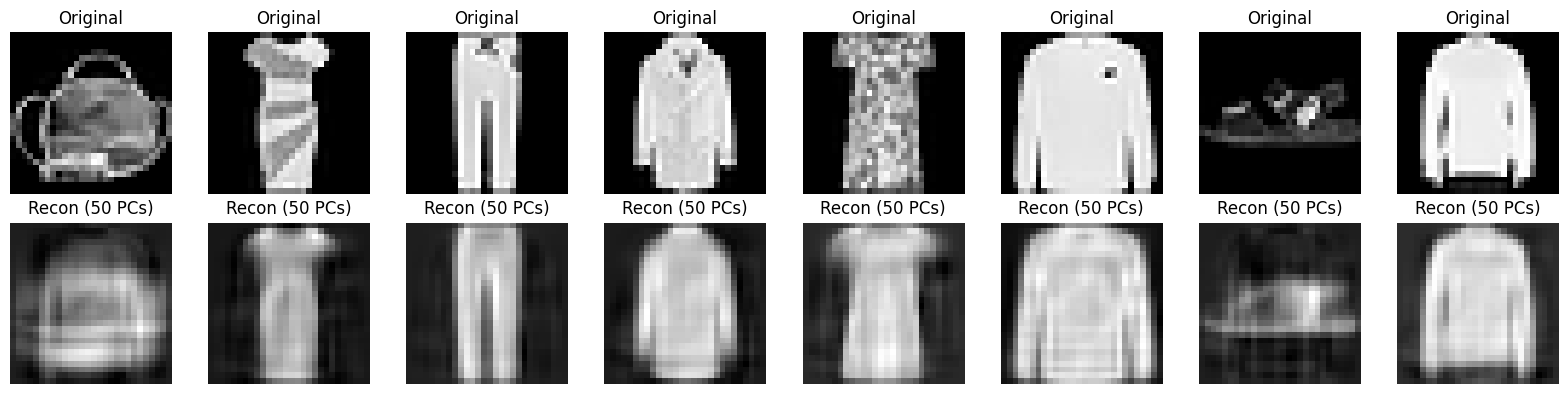

In [73]:
# Apply PCA with 50 principal components
pca_50 = PCA(n_components=50)
x_pca_50 = pca_50.fit_transform(x_pca)          # Shape: (n_samples, 50)
x_recon_50 = pca_50.inverse_transform(x_pca_50) # Reconstructed images (n_samples, 784)

# Choose sample indices to visualize
indices = [0, 1, 2, 3, 4, 5, 6, 7]

plt.figure(figsize=(len(indices)*2, 4))

for i, idx in enumerate(indices):
    # Original image
    plt.subplot(2, len(indices), i + 1)
    plt.imshow(x_pca[idx].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title("Original")
    
    # Reconstructed image using 50 PCs
    plt.subplot(2, len(indices), i + 1 + len(indices))
    plt.imshow(x_recon_50[idx].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.title("Recon (50 PCs)")

plt.tight_layout()
plt.show()


# KMeans clustering

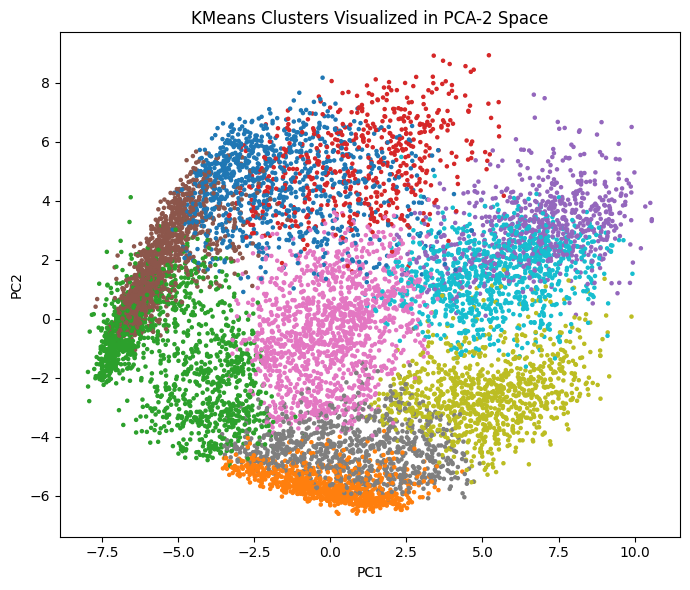

In [74]:
from sklearn.cluster import KMeans

# Use PCA-50 features for clustering
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_ids = kmeans.fit_predict(x_pca_50)

# Visualize clusters using PCA-2 coordinates
plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    x_pca_2d[:, 0],
    x_pca_2d[:, 1],
    c=cluster_ids,
    cmap="tab10",
    s=5
)

plt.title("KMeans Clusters Visualized in PCA-2 Space")
plt.xlabel("PC1")
plt.ylabel("PC2")

plt.tight_layout()
plt.show()


# t-SNE on CNN embeddings

In [75]:
import numpy as np

# Extract CNN features (128-dim) for a subset of test samples
max_samples = 2000   # t-SNE is expensive; 2k samples is enough

feature_list = []
label_list = []

cnn_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)

        # Forward pass until the penultimate layer
        x = cnn_model.conv_layer(images)          # (batch, 64, 7, 7)
        x = x.view(x.size(0), -1)                 # flatten conv output
        x = cnn_model.fc_layer[1](cnn_model.fc_layer[0](x))  # Linear
        x = cnn_model.fc_layer[2](x)              # ReLU → features (batch, 128)

        feature_list.append(x.cpu().numpy())
        label_list.append(labels.numpy())

        # Stop when we have enough samples
        if sum(len(b) for b in label_list) >= max_samples:
            break

features = np.concatenate(feature_list, axis=0)[:max_samples]  # (max_samples, 128)
tsne_labels = np.concatenate(label_list, axis=0)[:max_samples] # (max_samples,)

print(features.shape, tsne_labels.shape)


(2000, 128) (2000,)


In [76]:
from sklearn.manifold import TSNE

# Apply t-SNE to 128-dim CNN features
tsne = TSNE(
    n_components=2,
    perplexity=30,
    learning_rate="auto",
    init="random",
    random_state=42
)

features_2d = tsne.fit_transform(features)  # Shape: (max_samples, 2)
print(features_2d.shape)


(2000, 2)


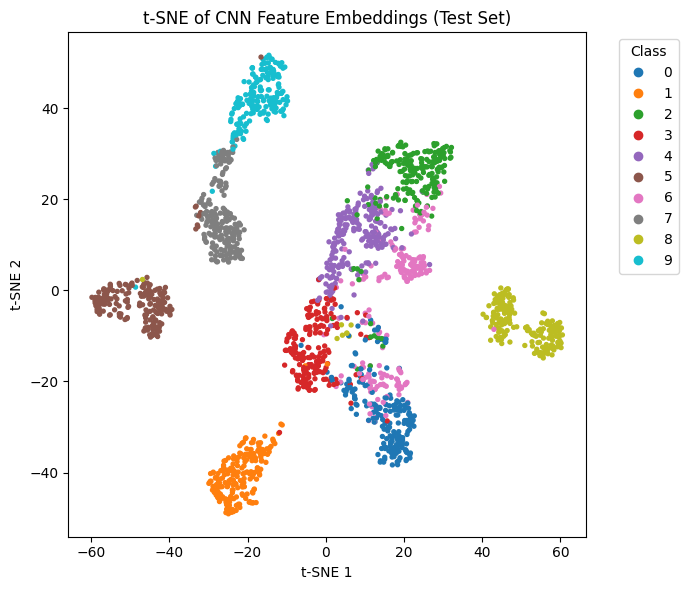

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    features_2d[:, 0],
    features_2d[:, 1],
    c=tsne_labels,
    cmap="tab10",
    s=8
)

plt.title("t-SNE of CNN Feature Embeddings (Test Set)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")

handles, labels = scatter.legend_elements(num=10)
plt.legend(handles, labels, title="Class", bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


#

In [88]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# 1. Helper function to extract CNN embeddings (penultimate layer)
def extract_features(model, dataloader, device):
    model.eval()
    all_features = []
    all_images = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)

            # Forward until the penultimate layer
            x = model.conv_layer(images)          # (batch, 64, 7, 7)
            x = x.view(x.size(0), -1)            # flatten conv output
            x = model.fc_layer[1](model.fc_layer[0](x))  # Linear
            x = model.fc_layer[2](x)             # ReLU -> features (batch, 128)

            all_features.append(x.cpu().numpy())
            all_images.append(images.cpu().numpy())
            all_labels.append(labels.numpy())

    features = np.concatenate(all_features, axis=0)   # (N, 128)
    images = np.concatenate(all_images, axis=0)       # (N, 1, 28, 28)
    labels = np.concatenate(all_labels, axis=0)       # (N,)

    return features, images, labels

# 2. Actually extract features on the test set
test_features, test_images, test_labels = extract_features(
    cnn_model, test_loader, device
)

print("Feature shape:", test_features.shape)
print("Image shape:", test_images.shape)
print("Label shape:", test_labels.shape)


Feature shape: (10000, 128)
Image shape: (10000, 1, 28, 28)
Label shape: (10000,)


In [89]:
# Normalize feature vectors for cosine similarity
# This makes dot product equivalent to cosine similarity
feature_norms = np.linalg.norm(test_features, axis=1, keepdims=True)
normed_features = test_features / (feature_norms + 1e-8)


def show_similar_items(query_index, top_k=5):
    """
    Given a query index in the test set,
    show the query image and its top-k most similar images
    based on cosine similarity of CNN embeddings.
    """
    # 1. Get query feature and compute cosine similarity to all others
    query_feat = normed_features[query_index]              # (128,)
    sims = normed_features @ query_feat                   # (N,)
    
    # 2. Sort by similarity (descending)
    sorted_idx = np.argsort(-sims)
    
    # First one is the query itself, so we skip index 0
    top_idx = sorted_idx[1: top_k + 1]

    # 3. Plot query + top-k results
    plt.figure(figsize=(2 * (top_k + 1), 3))

    # Plot query image
    plt.subplot(1, top_k + 1, 1)
    plt.imshow(test_images[query_index, 0], cmap="gray")
    plt.title(f"Query\nLabel: {test_labels[query_index]}")
    plt.axis("off")

    # Plot top-k similar images
    for i, idx in enumerate(top_idx):
        plt.subplot(1, top_k + 1, i + 2)
        plt.imshow(test_images[idx, 0], cmap="gray")
        plt.title(f"Sim {i+1}\nLabel: {test_labels[idx]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


Query index: 4607, label: 5


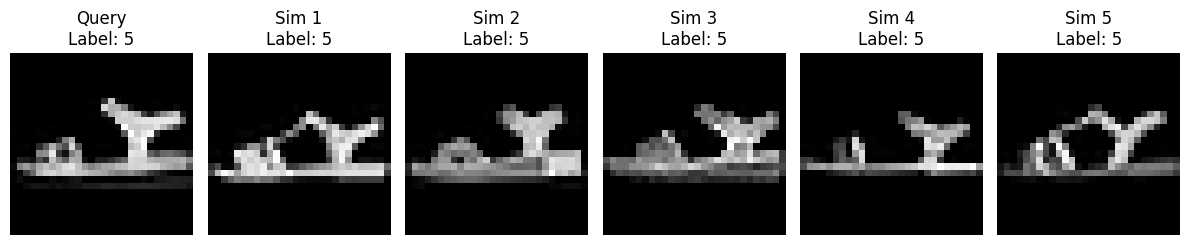

Query index: 2530, label: 9


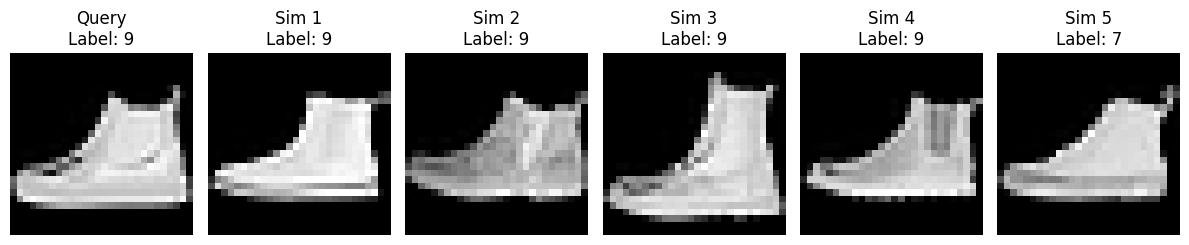

Query index: 9115, label: 9


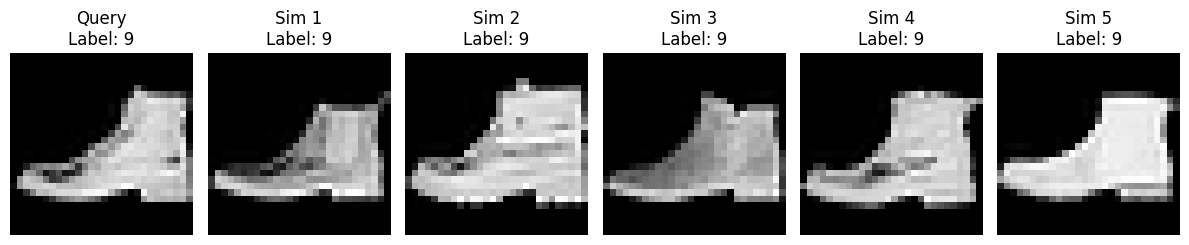

In [90]:
# Example: show similar items for a few random queries
import random

for _ in range(3):
    q = random.randint(0, len(test_labels) - 1)
    print(f"Query index: {q}, label: {test_labels[q]}")
    show_similar_items(q, top_k=5)
